Exercise 3
=========

In this exercise you should invetigate model order reduction by a modeal basis.
You should be able to re-use many parts from the previous exercises.

Consider the plate clamped at all edges.

In [1]:
from scipy.io import mmread
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import inv

import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
matplot.rcParams.update({'figure.max_open_warning': 0})

# Uncomment the following line and edit the path to ffmpeg if you want to write the video files!
#plt.rcParams['animation.ffmpeg_path'] ='N:\\Applications\\ffmpeg\\bin\\ffmpeg.exe'

from mpl_toolkits.mplot3d import Axes3D

import sys
np.set_printoptions(threshold=50)

from numpy.fft import rfft, rfftfreq

from utility_functions import Newmark

In [2]:
M = csc_matrix(mmread('Ms.mtx')) # mass matrix
K = csc_matrix(mmread('Ks.mtx')) # stiffness matrix
C = csc_matrix(K.shape) # a zeros damping matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes

N = X.shape[0] # number of nodes

nprec = 6 # precision for finding uniqe values

# get grid vectors (the unique vectors of the x,y,z coodinate-grid)
x = np.unique(np.round(X[:,0],decimals=nprec))
y = np.unique(np.round(X[:,1],decimals=nprec))
z = np.unique(np.round(X[:,2],decimals=nprec))

# grid matrices
Xg = np.reshape(X[:,0],[len(y),len(x),len(z)])
Yg = np.reshape(X[:,1],[len(y),len(x),len(z)])
Zg = np.reshape(X[:,2],[len(y),len(x),len(z)])

tol = 1e-12

# constrain all edges
Nn = np.argwhere(np.abs(X[:,1]-X[:,1].max())<tol).ravel() # Node indices of N-Edge nodes
No = np.argwhere(np.abs(X[:,0]-X[:,0].max())<tol).ravel() # Node indices of O-Edge nodes
Ns = np.argwhere(np.abs(X[:,1]-X[:,1].min())<tol).ravel() # Node indices of S-Edge nodes
Nw = np.argwhere(np.abs(X[:,0]-X[:,0].min())<tol).ravel() # Node indices of W-Edge nodes

Nnosw = np.unique(np.concatenate((Nn,No,Ns,Nw))) #concatenate all and only take unique (remove the double ones)

# special points and the associated nodes
P1 = [0.2,0.12,0.003925]
N1 = np.argmin(np.sum((X-P1)**2,axis=1))
P2 = [0.0,-0.1,0.003925]
N2 = np.argmin(np.sum((X-P2)**2,axis=1))

# all node on the top of the plate
Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol).ravel()

# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# select which indices in the global system must be constrained
If = np.array([Ix[Nnosw],Iy[Nnosw],Iz[Nnosw]]).ravel() # dof indices of fix constraint
Ic = np.array([(i in If) for i in np.arange(3*N)]) # boolean array of constraind dofs

# compute the reduced system
Kc = csc_matrix(K[np.ix_(~Ic,~Ic)])
Mc = csc_matrix(M[np.ix_(~Ic,~Ic)])
Cc = csc_matrix(C[np.ix_(~Ic,~Ic)])

# Constraint Enforcement
You can enforce contraints as in the previous exercises by selecting the appropriate rows from the system matrices, or use the nullsapce of the constraint matrix.

Set up a constraint matrix and use the provided function for computing the nullspace
```python
from utlity_functions import nullspace
```

In [3]:
from utility_functions import nullspace

# Mode Shapes
Compute a set of mode-shapes of the system.

## Modal mass participation factor

Compute the modal mass participation factor for all 6  for the first 10 modes of the plate.

First you need to define the ridig body degrees of freedom (3 displacements and 3 rotations) in terms of displacement fields (can be seen as "mode shapes").

Then compute the 6 modal mass participation factors for each mode.
Which ridid body displacement is most represented in which mode?

# Static Deformation

Check your bondary conditions by computing a static deformation: Assume a pressure acting on the plate (in transverse =z direction) which is linearly increasing from zero at one short edge (e.g. $x=x_{\min}$) to the oppsite edge. 
Assume a maximal pressure of 10kPa.
For the sake of simplicity you can apply the pressure to one "node layer" (in thichness direction).
Force per node can be obtained by multiplying by the "nodal area", i.e. the total area of the plate divided by the number of nodes in the "node layer".

Approximate the computed static displacement using the first three oscillation modes.
* What are the required modal coordinates?
* Plot the residual, which mode should you include to improve the approximation?

# Transient Solution

We'll investigate the plate in the same configuration as in Exercise 2, but now compute results using reduced order models.

One can use the Newmark time intragration both for the full system and in the modal coodinates.

### Forcing
Use the forcing given in Task 1 of Exercise 2: $f(t) = 1-e^{-(t/0.002)^2}$ in z-direction at $P_1= [0.2,0.12,0.003925]$.

### Damping
For the sake of simplicity assume Rayleigh damping with $\alpha=2.15$ and $\beta=3e-5$.

## Task 1: Transient Response using Reduced Model

Use a modal basis of the first two modes and compute the transient response of the system (under the same loading as in Task 1 of Exercise 2). Plot the response at points P1 and P2, and compare with the full system.
What is the error with respect to the full system?

### Choice of Modes
* How does the error improve when you take more modes?
* Plot the response at selected nodes, e.g. N1, N2, center, for different models in the same graph.

### Time Evolution of Modal Corrdinates
* Visualize the time evolution of the used modal coordinates
* Do this for the results obtained with differnt modal bases
* Compute the modal contributions in the same way. Which modes contribute most for which model?

# Steady State Oscillation | Frequency Domain

Now switch to frequency domain and compute the steady state response of the system.
For the sake of simplicity use a unit excitation at $P_1$.

In [4]:
from numpy.linalg import solve
import time

In [45]:
def FrequencyDomain(omega, direc = Iz, node = N1, K = Kc, C = Cc, M = Mc):
    #1. Compute the dynamic stiffness matrix Z for one omega
    Z = K + complex(0,1) * omega * C - omega**2 * M     
    
    #2. Assemble one (or several) forcing vectors
    f_hat = np.zeros(3*N)
    f_hat[direc[node]] = 1.0    #for sys without constrains and force acting on N1 which is the closest node to P1
    fc_hat = f_hat[~Ic]    #for reduced sys, because of constrains
    
    fc_hat_red = V.transpose() @ fc_hat #reduced forcing vector
    
    #3. solve for the displacements
    xc_hat_red = solve(Z,fc_hat_red)       #for np.array matrices
    
    return(xc_hat_red) #complex, so ampl and phase is in there; for all DoF which are not constrained

## Task 2: Compute Harmonic Response using a Reduced Model

Use the first 10 modes to compute the steady state response for a unit forcing in z-direction at $P_1$.
Do the computation for Rayleigh damping and for Modal damping with a damping ratio of 0.01 for each mode.
Compare the results by plotting the transfer functions up to 300Hz.

In [46]:
## only compute a subset of modes of the reduced model
k = 10
W,V = eigsh(Kc,k,Mc,sigma=0,which='LM',maxiter = 1000)

In [47]:
def ResponseOverReducedSystem(max_freq = 300., min_freq = 2., Nr_steps = 150.):
    
    ## Compute the reduced system matrices and forcing vector
    M_red = V.transpose() @ Mc @ V
    C_red = V.transpose() @ Cc @ V
    K_red = V.transpose() @ Kc @ V

    ## Solve the reduced system for the modal coordinates eta and transforamtion to obtain the full solution
    P1_resp_z = np.zeros([int(Nr_steps-1.),2])
    eta_hat_store = []
    freq_store = []

    steps = (max_freq-min_freq)/Nr_steps
    
    counter = 0

    for i in range(2, 300, round(steps)):
        # response of the reduced system M_red K_red C_red
        eta_hat = FrequencyDomain(omega = 2*np.pi*i, K = K_red, C = C_red, M = M_red)
        eta_hat_store.append(eta_hat)
        freq_store.append(i)

        # coordinate transformation to obtain the full solution
        resp = V @ eta_hat

        # insert missing nodes with zero, because of the constrains
        resp_all = np.zeros(N*3) + complex(0,0)
        resp_all[~Ic] = resp

        #Amplitude displacement
        #P1_resp_z[counter,0] = 20*np.log10(np.abs(resp_all[Iz[N1]]))
        P1_resp_z[counter,0] = np.abs(resp_all[Iz[N1]])

        #Phase in degree
        P1_resp_z[counter,1] = np.angle(resp_all[Iz[N1]])*180/np.pi

        counter += 1
    eta_hat_store = np.asarray(eta_hat_store)
    return(P1_resp_z, steps, eta_hat_store, freq_store)

In [48]:
dampingRatio = 0.01 # Damping ratio choosen

In [49]:
### Rayleigh damping like ex.2
## getting alpha and beta
omegas = np.sqrt(abs(W)) # Collect angular eigenfrq.
omegaCoeffs = np.vstack((0.5/omegas, omegas*0.5)).T # Build coefficent matrix  

b = dampingRatio*np.ones(np.shape(omegaCoeffs)[0]) # Right-hand side of omegaCoeffs*alphaBeta = b

alphaBeta = np.linalg.solve(omegaCoeffs[(0,4),:], b.take([0,4])) # Solve for alphaBeta at 1. and 5. natural frequency

dampingRatios = omegaCoeffs @ alphaBeta 

start_time = time.time()

## assemble Damping-Matrix for the reduced sys and given aplha and beta for Rayleigh damping
alpha = alphaBeta[0]
beta = alphaBeta[1]
Cc = alpha * Mc + beta * Kc

response_steps_ModalCoordinates_frequency = ResponseOverReducedSystem()
P1_resp_z_ray = response_steps_ModalCoordinates_frequency[0]
steps = response_steps_ModalCoordinates_frequency[1]
eta_hat_ray = response_steps_ModalCoordinates_frequency[2]
frequency = response_steps_ModalCoordinates_frequency[3]

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0997154712677002 seconds ---


In [50]:
### Modal damping
start_time = time.time()

##  assemble Cc-Matrix
container = np.array(2*np.sqrt(W)*dampingRatio)
diagMiddle = np.diag(container)
Cc = V @ diagMiddle @ V.transpose()

response_steps_ModalCoordinates = ResponseOverReducedSystem()
P1_resp_z_mod = response_steps_ModalCoordinates[0]
steps = response_steps_ModalCoordinates[1]
eta_hat_mod = response_steps_ModalCoordinates[2]
frequency = response_steps_ModalCoordinates_frequency[3]

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2346630096435547 seconds ---


In [51]:
Cc.shape

(5460, 5460)

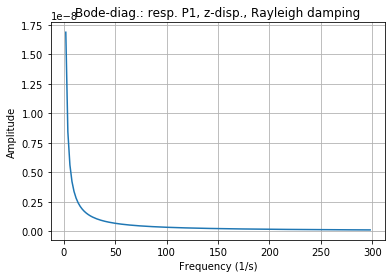

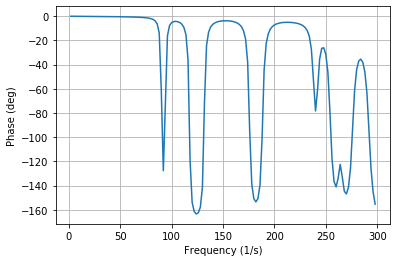

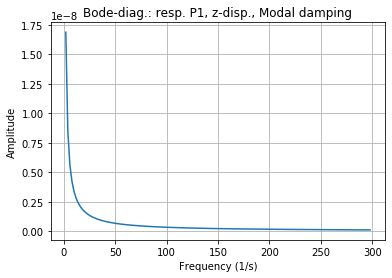

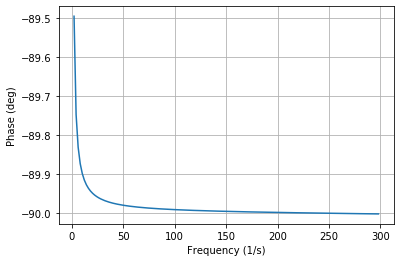

In [33]:
### Plot of transfer functions up to 300Hz (Bode-Diag.)

#plot response in z for P1 with Rayleigh damping
# plt.plot(frequency, P1_resp_z_ray[:,0])
plt.plot(frequency, P1_resp_z_mod[:,0])
plt.title('Bode-diag.: resp. P1, z-disp., Rayleigh damping')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/s)')
# plt.xscale('log')
# plt.xlim(1, 1000)
plt.grid(True)
plt.show()

plt.plot(frequency, P1_resp_z_ray[:,1])
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (1/s)')
# plt.xscale('log')
# plt.xlim(1, 1000)
plt.grid(True)
plt.show()

#plot response in z for P1 with Modal damping
plt.plot(frequency, P1_resp_z_mod[:,0])
plt.title('Bode-diag.: resp. P1, z-disp., Modal damping')
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/s)')
# plt.xscale('log')
# plt.xlim(1, 1000)
plt.grid(True)
plt.show()

plt.plot(frequency, P1_resp_z_mod[:,1])
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (1/s)')
#plt.xscale('log')
#plt.xlim(1, 1000)
plt.grid(True)
plt.show()

### Compare damping models
* what is the difference between modal and Rayleigh damping?
* what happens if you only damp certain modes with modal damping?

In [12]:
# weiß noch nicht genau was er da genau von mir will
# In Diag einige null setzen

### Modal contribution
* compute the modal contribution factors for each mode and plot them over the frequency
* When is which mode important?

In [13]:
### Modal Contribution factor for each mode
rho = np.zeros([len(frequency), k]) + complex(0,0)

for i in range(len(frequency)):
    for j in range(k):
        rho[i,j] = eta_hat_mod[i,j]/abs(eta_hat_mod[i,j])


In [14]:
print(eta_hat_ray[0,0])

(8.862458029618508e-07-3.9287180420745404e-10j)


In [15]:
print(abs(eta_hat_ray[0,0]))

8.86245890041669e-07


In [16]:
rho.shape

(149, 10)

In [17]:
rho

array([[ 3.66254216e-03-0.99999329j,  4.66777748e-03-0.99998911j,
         6.78346430e-03-0.99997699j, ...,  1.28520398e-02-0.99991741j,
         1.50992357e-02-0.999886j  , -1.77878775e-02+0.99984178j],
       [ 1.82861119e-03-0.99999833j,  2.33188870e-03-0.99999728j,
         3.39046833e-03-0.99999425j, ...,  6.42581412e-03-0.99997935j,
         7.54924936e-03-0.9999715j , -8.89423790e-03+0.99996045j],
       [ 1.21610862e-03-0.99999926j,  1.55235013e-03-0.9999988j ,
         2.25884959e-03-0.99999745j, ...,  4.28325711e-03-0.99999083j,
         5.03187599e-03-0.99998734j, -5.92893243e-03+0.99998242j],
       ...,
       [-2.36741615e-04-0.99999997j, -1.66232333e-04-0.99999999j,
        -8.34951459e-05-1.j        , ...,  2.85418478e-05-1.j        ,
         1.22927899e-05-1.j        , -6.18419001e-05+1.j        ],
       [-2.38690106e-04-0.99999997j, -1.67793856e-04-0.99999999j,
        -8.46889519e-05-1.j        , ...,  2.75503864e-05-1.j        ,
         1.09834474e-05-1.j        

/home/max/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


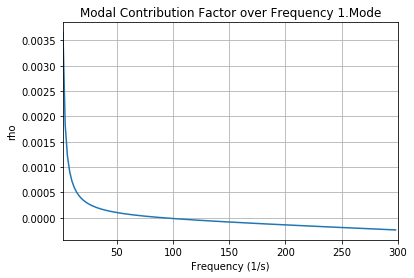

/home/max/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


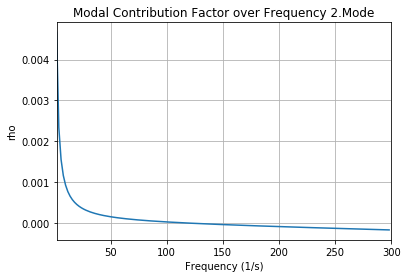

/home/max/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


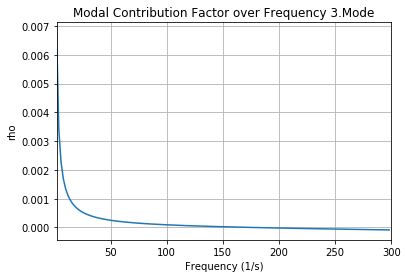

/home/max/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


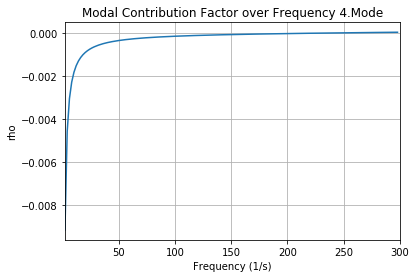

/home/max/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


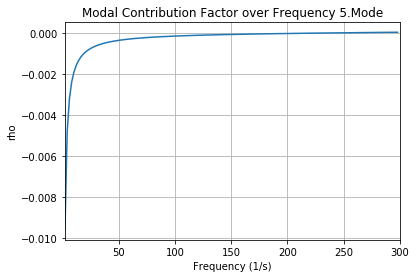

/home/max/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


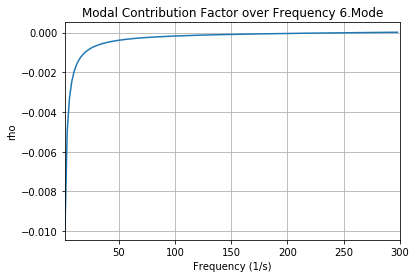

/home/max/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


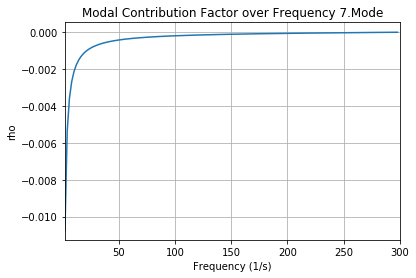

/home/max/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


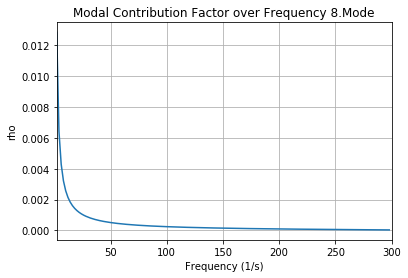

/home/max/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


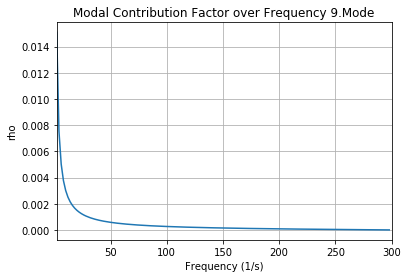

/home/max/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


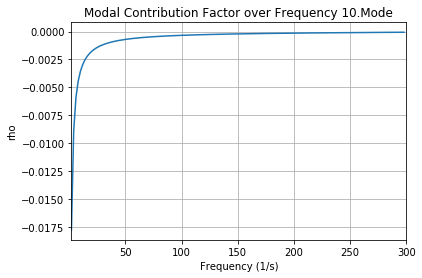

In [18]:
#plot modal Contribution Factor over the frequency 1.Mode
plt.plot(frequency, rho[:,0])
plt.title('Modal Contribution Factor over Frequency 1.Mode')
plt.ylabel('rho')
plt.xlabel('Frequency (1/s)')
plt.xlim(2, 300)
plt.grid(True)
plt.show()

#plot modal Contribution Factor over the frequency 2.Mode
plt.plot(frequency, rho[:,1])
plt.title('Modal Contribution Factor over Frequency 2.Mode')
plt.ylabel('rho')
plt.xlabel('Frequency (1/s)')
plt.xlim(2, 300)
plt.grid(True)
plt.show()

#plot modal Contribution Factor over the frequency 3.Mode
plt.plot(frequency, rho[:,2])
plt.title('Modal Contribution Factor over Frequency 3.Mode')
plt.ylabel('rho')
plt.xlabel('Frequency (1/s)')
plt.xlim(2, 300)
plt.grid(True)
plt.show()

#plot modal Contribution Factor over the frequency 4.Mode
plt.plot(frequency, rho[:,3])
plt.title('Modal Contribution Factor over Frequency 4.Mode')
plt.ylabel('rho')
plt.xlabel('Frequency (1/s)')
plt.xlim(2, 300)
plt.grid(True)
plt.show()

#plot modal Contribution Factor over the frequency 5.Mode
plt.plot(frequency, rho[:,4])
plt.title('Modal Contribution Factor over Frequency 5.Mode')
plt.ylabel('rho')
plt.xlabel('Frequency (1/s)')
plt.xlim(2, 300)
plt.grid(True)
plt.show()

#plot modal Contribution Factor over the frequency 6.Mode
plt.plot(frequency, rho[:,5])
plt.title('Modal Contribution Factor over Frequency 6.Mode')
plt.ylabel('rho')
plt.xlabel('Frequency (1/s)')
plt.xlim(2, 300)
plt.grid(True)
plt.show()

#plot modal Contribution Factor over the frequency 7.Mode
plt.plot(frequency, rho[:,6])
plt.title('Modal Contribution Factor over Frequency 7.Mode')
plt.ylabel('rho')
plt.xlabel('Frequency (1/s)')
plt.xlim(2, 300)
plt.grid(True)
plt.show()

#plot modal Contribution Factor over the frequency 8.Mode
plt.plot(frequency, rho[:,7])
plt.title('Modal Contribution Factor over Frequency 8.Mode')
plt.ylabel('rho')
plt.xlabel('Frequency (1/s)')
plt.xlim(2, 300)
plt.grid(True)
plt.show()

#plot modal Contribution Factor over the frequency 9.Mode
plt.plot(frequency, rho[:,8])
plt.title('Modal Contribution Factor over Frequency 9.Mode')
plt.ylabel('rho')
plt.xlabel('Frequency (1/s)')
plt.xlim(2, 300)
plt.grid(True)
plt.show()

#plot modal Contribution Factor over the frequency 10.Mode
plt.plot(frequency, rho[:,9])
plt.title('Modal Contribution Factor over Frequency 10.Mode')
plt.ylabel('rho')
plt.xlabel('Frequency (1/s)')
plt.xlim(2, 300)
plt.grid(True)
plt.show()

In [19]:
summe = 0
for i in rho[:,9]:
    summe =+ abs(i)

In [20]:
summe

0.9999999999999999

In [56]:
from scipy.sparse.linalg import spsolve
def FrequencyDomain(omega, direc = Iz, node = N1):
    #1. Compute the dynamic stiffness matrix K for one omega
    #Z = Kc.toarray() + complex(0,1) * omega * Cc.toarray() - omega**2 * Mc.toarray() #for sparse matrices
    Z = Kc + complex(0,1) * omega * Cc - omega**2 * Mc     #for np.arrays
    
    #2. Assemble one (or several) forcing vectors
    f_hat = np.zeros(3*N)
    f_hat[direc[node]] = 1.0    #for sys without constrains and force acting on N1 which is the closest node to P1
    fc_hat = f_hat[~Ic]    #for reduced sys, because of constrains
    
    #3. solve for the displacements
    xc_hat = spsolve(Z,fc_hat)       #for spare matrices
    #x_hat = np.linalg.solve(Z,fc_hat)   #for np.array's
    
    return(xc_hat) #complex, so ampl and phase is in there; for all DoF which are not constrained

In [57]:
#UNDAMPED
start_time = time.time()

container = np.array(2*np.sqrt(W)*dampingRatio)
diagMiddle = np.diag(container)
Ccc = V @ diagMiddle @ V.transpose()
Cc = csc_matrix(Ccc)


#frequency range from 2Hz to 300Hz and ~150 frequency points
Nr_steps = 150.
steps = (300.-2.)/Nr_steps

P1_resp_z_undamped = np.zeros([int(Nr_steps-1.),2]) #+ complex(0,0)

counter = 0

for i in range(2, 300, round(steps)):
    resp = FrequencyDomain(2*np.pi*i)
    print(i)
    # insert missing nodes with zero
    resp_all = np.zeros(N*3) + complex(0,0)
    resp_all[~Ic] = resp
    
    #Amplitude in dB
    P1_resp_z_undamped[counter,0] = (np.abs(resp_all[Iz[N1]]))

    #Phase in deg
    P1_resp_z_undamped[counter,1] = np.angle(resp_all[Iz[N1]])*180/np.pi
    
    counter += 1
    
print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [ ]:
#plot response in z for P1
plt.plot(frequency, P1_resp_z_undamped[:,0])
plt.title('Bodediagramm: response P1, z-displacement')
plt.ylabel('Amplitude (dB)')
plt.xlabel('Frequency (rad/s)')
# plt.xscale('log')
# plt.xlim(1, 1000)
plt.grid(True)
plt.show()

plt.plot(frequency, P1_resp_z_undamped[:,1])
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (rad/s)')
plt.xscale('log')
# plt.xlim(1, 1000)
# plt.grid(True)
plt.show()